In [79]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.nn import Module, Parameter
import numpy as np
import math

In [80]:
def ricker(freq, length, dt, peak_time):
    """Return a Ricker wavelet with the specified central frequency.
    Args:
        freq: A float specifying the central frequency
        length: An int specifying the number of time samples
        dt: A float specifying the time sample spacing
        peak_time: A float specifying the time (in secs) of the peak amplitude
        dtype: The PyTorch datatype to use. Optional, defaults to default.
    """
    t = np.arange(0,length)*dt - peak_time
    y = (1-2*math.pi**2 * freq**2 * t**2) * np.exp(-math.pi**2 * freq**2 * t**2)
    return y

In [81]:
class RNNCell_FD(Module):
    def __init__(self, dx, dt, isrc, nx):
        super(RNNCell_FD, self).__init__()
        self.dx = dx
        self.isrc = isrc
        self.nx = nx
        self.dt = dt
        kernel = [1/(dx**2), -2/(dx**2), 1/(dx**2)]
        kernel = torch.FloatTensor(kernel).unsqueeze(0).unsqueeze(0)
        vel = torch.cat((torch.ones(60)*5000, torch.ones(50)*4000,
                         torch.ones(40)*3000, torch.ones(50)*2000))
        vel = vel.unsqueeze(0).unsqueeze(0)
        self.vel = Parameter(data=vel, requires_grad=True)
        self.weight_conv = Parameter(data=kernel, requires_grad=False)
        
        
    def forward(self, input, h_current, h_old):
        vel = self.vel
        if vel.shape[-1] != self.nx:
            print(f'[ERROR]: velocity model length {vel.shape[-1]} != {nx}!')
            pause
        d2px = F.conv1d(h_current, self.weight_conv)
        if d2px.shape[-1] != self.nx and (self.nx - d2px.shape[-1]) % 2 == 0:
            padd = int((self.nx - d2px.shape[-1]) / 2)
            d2px = torch.cat((torch.zeros(1,1,padd), d2px, torch.zeros(1,1,padd)), 2)
        else:
            print(f'[ERROR]: Conv lenght {nx} - {d2px.shape[-1]} ={self.nx - d2px.shape[-1]} !')
        h_next = d2px * self.dt**2 * vel**2 - h_old + 2 * h_current
        h_next[0,0,self.isrc] = h_next[0,0,self.isrc] + input * self.dt**2 * 1 / self.dx
        h_next[0,0,-1] = h_next[0,0,-2] - 1/vel[0,0,-1] * (h_next[0,0,-2] - h_current[0,0,-2])*self.dx/self.dt
        h_next[0,0,0] = 0
        return h_current, h_next
        

In [82]:
dt = 0.001                     # delta
timeLen = 1                    # in second
nt = int(timeLen/dt)           # sample points
peak_freq = 10                  # in Hz
peak_sorce_time = 1/peak_freq  #
source_amplitudes = ricker(peak_freq, nt, dt, peak_sorce_time)
src = source_amplitudes

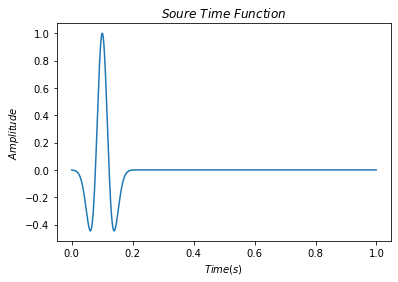

In [83]:
# plot source time function
import matplotlib.pyplot as plt

plt.figure(1)
plt.plot(np.arange(0,nt)*dt,source_amplitudes)
plt.xlabel('$Time(s)$')
plt.ylabel('$Amplitude$')
plt.title('$Soure\ Time\ Function$')
#plt.grid(ls='--')
plt.show()

<generator object Module.parameters at 0x0000017F6320D120>
torch.Size([1, 1, 200]) torch.Size([1, 1, 200])


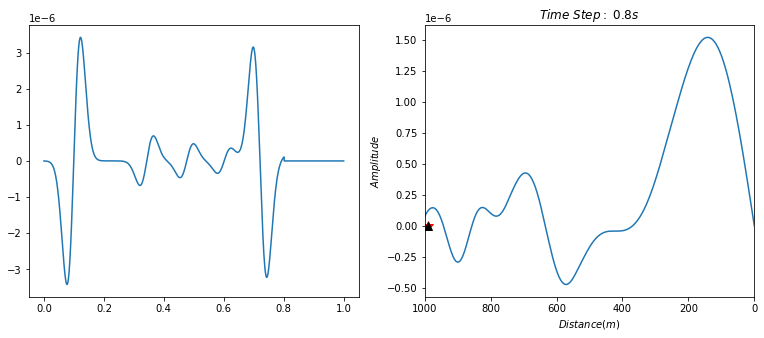

In [96]:
# 1D Wave Propagation (Finite Difference Solution)

nx   = 200         # number of grid points in x-direction
dx   = 5          # grid point distance in x-direction
isrc = 198          # source location in grid in x-direction
ir   = 198          # receiver location in grid in x-direction

h_current = torch.zeros(1,1,nx)
h_old = torch.zeros(1,1,nx)

seis = np.zeros(nt)

net = RNNCell_FD(dx, dt, isrc, nx)

check_it = 800
for it in range(nt):
    h_old, h_current = net(src[it], h_current, h_old)
    seis[it] = h_current[0,0,ir]
    if it == range(nt)[check_it]:
        print(h_old.shape, h_current.shape)
        plt.figure(figsize=(13,5))
        ax1 = plt.subplot(121)
        time = np.linspace(0 * dt, nt * dt, nt)
        ax1.plot(time, seis)
        
        ax2 = plt.subplot(122)
        ax2.plot(np.linspace(0 * dx, nx * dx, nx), h_old[0,0,:].detach().numpy())
        ax2.plot(isrc*dx, 0, 'r*', markersize=11)
        ax2.plot(ir*dx, 0, 'k^', markersize=8)
        ax2.set_xlim([0, nx*dx])
        ax2.set_xlabel('$Distance(m)$')
        ax2.set_ylabel('$Amplitude$')
        ax2.set_title(f'$Time\ Step:\ {it*dt}s$')
        ax2.invert_xaxis()
        

In [101]:
for name,p in net.named_parameters():
    print(name,p)

vel Parameter containing:
tensor([[[5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000.,
          5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000.,
          5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000.,
          5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000.,
          5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000.,
          5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000.,
          4000., 4000., 4000., 4000., 4000., 4000., 4000., 4000., 4000., 4000.,
          4000., 4000., 4000., 4000., 4000., 4000., 4000., 4000., 4000., 4000.,
          4000., 4000., 4000., 4000., 4000., 4000., 4000., 4000., 4000., 4000.,
          4000., 4000., 4000., 4000., 4000., 4000., 4000., 4000., 4000., 4000.,
          4000., 4000., 4000., 4000., 4000., 4000., 4000., 4000., 4000., 4000.,
          3000., 3000., 3000., 3000., 3000., 3000., 3000., 3000., 3000., 3000.,
          3000

In [22]:
a = torch.cat((torch.rand(1,1,5), torch.ones(1,1,5)), 2)
a

tensor([[[0.9805, 0.3539, 0.5406, 0.7381, 0.5943, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000]]])

In [31]:
a.shape

torch.Size([1, 1, 10])

In [13]:
F.conv1d(torch.rand(1,1,10), torch.rand(1,1,3)).squeeze(0).squeeze(0)

tensor([1.3070, 0.9897, 1.4262, 0.9293, 1.0681, 0.5637, 0.4808, 0.8218])